In [15]:
TOTAL_YEARS = 10
STEPS_PER_YEAR = 2

PERCENTILES = [50, 25, 75, 5, 95]

SIMULATION_CONFIG = {
    "invested": 80 * 1000,
    "investment_expected_return": 0.08,
    "investment_volatility": 0.18,
    "net_income_monthly": 1 * 1000,
    "inflation_expected": 0.03,
    "inflation_volatility": 0.02,
}

WIDGET_CONFIG = {
    "invested.slider.start": 0,
    "invested.slider.end": 200 * 1000,
    "invested.-.step": 10 * 1000,
    "invested.input.step": 1000,
    "-.slider.start": -0.3,
    "-.slider.end": 0.3,
    "investment_volatility.slider.start": 0.0,
    "investment_volatility.slider.end": 0.5,
    "inflation_expected.-.step": 0.005,
    "inflation_volatility.-.step": 0.005,
    "inflation_volatility.slider.start": 0.0,
    "inflation_volatility.slider.end": 0.5,
    "net_income_monthly.slider.start": -15 * 1000,
    "net_income_monthly.slider.end": 15 * 1000,
    "net_income_monthly.-.step": 100,
    "-.input.width": 150,
    "investment_expected_return.-.format": ".1%",
    "investment_volatility.-.format": ".1%",
    "inflation_expected.-.format": ".1%",
    "inflation_volatility.-.format": ".1%",
    "invested.-.format": ",.0f",
    "net_income_monthly.-.format": ",.0f",
    "-.-.step": 0.01,
}

OPTIMAL_TRAJECTORY_COUNT = 1000

# How long to listen for updates on input
# Should not be less than how long it takes to calculate optimal count of trajectory
UPDATE_PERIOD_IN_SECS = 5

# How frequently to poll during update period
UPDATE_INTERVAL_SECS = 0.75

In [16]:
%pip install matplotlib ipympl numpy pandas -qqqq

Note: you may need to restart the kernel to use updated packages.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import asyncio
import math
from matplotlib.ticker import MaxNLocator, FuncFormatter
import numpy as np
import pandas as pd
import matplotlib.axes
import matplotlib.dates as mdates
from datetime import timedelta
from typing import Optional
import ipywidgets as widgets
from functools import partial

# Enable the interactive widget backend for Matplotlib
%matplotlib widget

In [18]:
def simulate_gbm(invested: float, expected_return: float, volatility: float, steps_in_year: int) -> float:
    """
    Simulates the next-step growth of an investment using Geometric Brownian Motion (GBM)
    over a given fraction of a year.
    
    Parameters:
    - invested (float): Current amount of invested money.
    - expected_return (float): The expected annual return as a decimal (e.g., 0.07 for 7%).
    - volatility (float): The annualized volatility (standard deviation of returns).
    - steps_in_year (int): Number of simulation steps a year has (e.g., 12 for a monthly step).
    
    Returns:
    - float: The new value of the investment after the time step.
    """
    time_fraction = 1 / steps_in_year
    drift = (expected_return - 0.5 * volatility ** 2) * time_fraction  
    volatility_step = volatility * np.sqrt(time_fraction)  
    random_shock = volatility_step * np.random.randn()  
    growth_factor = np.exp(drift + random_shock)  
    return invested * growth_factor

In [19]:
def step_financial_growth(
    invested: float,
    investment_expected_return: float,
    investment_volatility: float,
    net_income_per_step: float,
    inflation_expected: float,
    inflation_volatility: float,
    steps_in_year: int
) -> float:
    """
    Simulates the next-step growth of an investment while considering income, expenses, and inflation.
    
    Parameters:
    - invested (float): Current amount of invested money.
    - expected_return (float): The expected annual return as a decimal (e.g., 0.07 for 7%).
    - volatility (float): The annualized volatility (standard deviation of returns).
    - net_income_per_step (float): income - expense, per time-step.
    - inflation_expected (float): The expected annual inflation rate.
    - inflation_volatility (float): The annualized volatility of inflation.
    - steps_in_year (int): Number of simulation steps per year (e.g., 12 for a monthly step).
    
    Returns:
    - float: The new value of the investment after the time step (inflation adjusted).
    - float: The new net income (inflation adjusted).
    """
    
    # Simulate investment growth
    new_invested = simulate_gbm(invested, investment_expected_return, investment_volatility, steps_in_year)
    
    # Simulate inflation impact
    inflation_factor = simulate_gbm(1, inflation_expected, inflation_volatility, steps_in_year)
    
    new_net_income_per_step = net_income_per_step * inflation_factor

    # Adjust for income
    new_invested += new_net_income_per_step
    
    # Adjust for inflation impact (reduce real value of investment)
    new_invested /= inflation_factor
    
    return new_invested, new_net_income_per_step

In [20]:
def simulate_period_of_growth(invested, investment_expected_return, investment_volatility,
                              net_income_monthly, inflation_expected, inflation_volatility,
                              steps_in_year, total_years):
    """
    Simulates the growth of an investment over a specified number of years.
    
    Parameters:
    - invested (float): Current amount of invested money.
    - investment_expected_return (float): The expected annual return as a decimal (e.g., 0.07 for 7%).
    - investment_volatility (float): The annualized volatility (standard deviation of returns).
    - net_income_monthly (float): income - expense, per time-step.
    - inflation_expected (float): The expected annual inflation rate.
    - inflation_volatility (float): The annualized volatility of inflation.
    - steps_in_year (int): Number of simulation steps per year (e.g., 12 for a monthly step).
    - total_years (int): Number of years to simulate.
    
    Returns:
    - Array[float]: The final value of the investment at each timestep, including the initial value.
    """
    
    per_time_step = [invested]
    total_steps = total_years * steps_in_year

    net_income_yearly = net_income_monthly * 12
    net_income_per_step = net_income_yearly / steps_in_year

    for _ in range(total_steps):
        invested, net_income = step_financial_growth(
            invested, investment_expected_return, investment_volatility,
            net_income_per_step, inflation_expected, inflation_volatility,
            steps_in_year
        )
        per_time_step.append(invested)
    
    return per_time_step

In [21]:
def update_simulation_config(**kwargs):
    """Updates the simulation configuration dictionary with provided key-value pairs."""
    for key, value in kwargs.items():
        if key in SIMULATION_CONFIG:
            SIMULATION_CONFIG[key] = value
        else:
            raise KeyError(f"{key} is not a valid variable.")

def reset_simulation_config(new_config):
    update_simulation_config(**new_config)

def gen_trajectory():
    return simulate_period_of_growth(
        invested=SIMULATION_CONFIG["invested"],
        investment_expected_return=SIMULATION_CONFIG["investment_expected_return"],
        investment_volatility=SIMULATION_CONFIG["investment_volatility"],
        net_income_monthly=SIMULATION_CONFIG["net_income_monthly"],
        inflation_expected=SIMULATION_CONFIG["inflation_expected"],
        inflation_volatility=SIMULATION_CONFIG["inflation_volatility"],
        steps_in_year=STEPS_PER_YEAR,
        total_years=TOTAL_YEARS,
    )

_total_steps = TOTAL_YEARS * STEPS_PER_YEAR

# Index is 1 element longer, because the generated data will include the starting point
INDEX_LENGTH = _total_steps + 1

def get_percentile_key(percentile):
    return f'p{percentile}'

DF_COLUMNS = list(map(get_percentile_key, PERCENTILES))

def generate_time_index(index_length: int, steps_in_year: int):
    """
    Generate a DataFrame with a DateTime index spanning a given number of years.
    
    Parameters:
    years (int): Number of years to span.
    steps_per_year (int): Number of time steps per year.
    
    Returns:
    pd.DataFrame: DataFrame with DateTime index and a separate year marker.
    """
    # Get today's date
    today = pd.Timestamp.today().normalize()
    
    # Determine frequency in days
    days_per_step = round(365.25 / steps_in_year)  # Account for leap years
    freq = f'{days_per_step}D'  # Use day-based frequency
    
    # Create a date range
    date_index = pd.date_range(start=today, periods=index_length, freq=freq)
    
    return date_index

_time_index = generate_time_index(INDEX_LENGTH, STEPS_PER_YEAR)

def init_df(data=None):
    return pd.DataFrame(data, columns=DF_COLUMNS, dtype=np.float64, index=_time_index)

# Preallocate percentile data
PERCENTILE_DATA = np.zeros((INDEX_LENGTH, len(PERCENTILES)))

def trajectories_to_percentile_data(trajectories):
    global PERCENTILE_DATA
    for i, p in enumerate(PERCENTILES):
        PERCENTILE_DATA[:, i] = np.percentile(trajectories, p, axis=0)
    return PERCENTILE_DATA

def trajectories_to_percentile_df(trajectories):
     percentile_data = trajectories_to_percentile_data(trajectories)
     return init_df(percentile_data)

# BUFFER = init_df();

# def send_to_buffer(df):
#     BUFFER = df

In [22]:
class TrajectoryCache:
    def __init__(self):
        self._trajectories = []
        self._cached_df = None
        self._is_dirty = True
        self._df_version = 0

    def get(self):
        return self._trajectories

    def reset(self, trajectories):
        self._trajectories = trajectories
        self._is_dirty = True
        return self.get()

    def get_percentile_df(self):
        if self._is_dirty:
            self._cached_df = trajectories_to_percentile_df(self._trajectories)
            self._is_dirty = False
            self._increment_version()
        return self._cached_df

    def get_percentile_df_with_version(self):
        df = self.get_percentile_df()
        return df, self._df_version

    def _increment_version(self):
        if self._df_version < 10000:
            self._df_version += 1
        else:
            self._df_version = 0 # wrap around

    def reinit(self):
        # One trajectory per percentile
        new_trajs = [gen_trajectory() for _ in range(len(PERCENTILES))]
        return self.reset(new_trajs)

    def reinit_if_empty(self):
        if len(self.get()) == 0:
            return self.reinit()
        return self.get()

    def append_multiple(self, trajectories):
        return self.reset(self.get() + trajectories)

TRAJECTORY_CACHE = TrajectoryCache()

In [23]:
LOCK_FOR_GEN_AND_APPEND_TRAJECTORIES = asyncio.Lock()
TERMINATE_EVENT_FOR_GEN_AND_APPEND_TRAJECTORIES = asyncio.Event()

def _sync_work():
    traj_data = gen_trajectory()
    TRAJECTORY_CACHE.append_multiple([traj_data])
    # Maybe return data if needed elsewhere immediately

loop = asyncio.get_running_loop()

async def gen_and_append_trajectories(n: int):
    # Have other processes surrender this calculation
    await trigger_early_termination_in_others()
    async with LOCK_FOR_GEN_AND_APPEND_TRAJECTORIES:
        try:
            # start_send_trajectories()
            for _ in range(n):
                if TERMINATE_EVENT_FOR_GEN_AND_APPEND_TRAJECTORIES.is_set():
                    break 
                # computationally expensive operation, especially when running in a loop
                #append_trajectory(gen_trajectory())
                await loop.run_in_executor(None, _sync_work)
            
            # Clear the terminate event after completing or being interrupted
            TERMINATE_EVENT_FOR_GEN_AND_APPEND_TRAJECTORIES.clear()
        finally:
            None
            # if not TERMINATE_EVENT_FOR_GEN_AND_APPEND_TRAJECTORIES.is_set():
            #     stop_send_trajectories()

async def trigger_early_termination_in_others():
    if LOCK_FOR_GEN_AND_APPEND_TRAJECTORIES.locked():
        TERMINATE_EVENT_FOR_GEN_AND_APPEND_TRAJECTORIES.set()

In [24]:
async def run_dynamic_plot(fig, ax, lines, update_period_in_secs):
    """
    Runs the main async loop that periodically updates the plot.
    """
    last_df_version = None
    UPDATE_INTERVAL_SECS = 0.5
    total_updates = update_period_in_secs / UPDATE_INTERVAL_SECS
    total_updates = math.ceil(total_updates)
    for _ in range(total_updates):
        df, df_version = TRAJECTORY_CACHE.get_percentile_df_with_version()
        should_update = df_version != last_df_version
        if should_update:
            await process_line_plot_update(
                fig=fig,
                ax=ax,
                lines=lines,
                df=df
            )
        await asyncio.sleep(UPDATE_INTERVAL_SECS)

async def process_line_plot_update(fig, ax, lines, df):
    """
    Executes a single update step:
    - generates data,
    - updates lines,
    - rescales axes,
    - redraws the canvas.
    
    Returns updated time_counter.
    """
    update_plot_lines(lines, df)
    adjust_axes_smooth(ax, df)
    fig.canvas.draw_idle()

def update_plot_lines(lines, df):
    """
    Updates the line objects in the plot with new y-values from the given DataFrame.
    Returns all y-values across lines for axis scaling.
    """
    for col_name, line in lines.items():
        y_data = df[col_name]
        line.set_data(df.index, y_data)

def adjust_axes_sharp(ax, df):
    """
    Dynamically rescales the plot axes to fit all line plots in the DataFrame.
    The DataFrame's index (datetime) is used as the x-axis and each column is a separate line plot.
    Adds a small padding to ensure visibility.
    """
    if df.empty:
        return
    x_data = df.index.values
    y_data = df.values
    min_x, max_x = x_data[0], x_data[-1]
    min_y, max_y = np.nanmin(y_data), np.nanmax(y_data)
    x_pad = (max_x - min_x) * 0.05 if max_x > min_x else 1
    y_pad = (max_y - min_y) * 0.1 if max_y > min_y else 1
    ax.set_xlim(min_x - x_pad, max_x + x_pad)
    ax.set_ylim(min_y - y_pad, max_y + y_pad)

def adjust_axes_smooth(
    ax: matplotlib.axes.Axes,
    df: pd.DataFrame,
    alpha: float = 0.5,  # Smoothing factor (0.0 to 1.0). 1.0 = instant jump (original behavior)
    padding_x_pct: float = 0.05,
    padding_y_pct: float = 0.10,
    min_y_range: Optional[float] = None, # Optional minimum span for y-axis
    min_x_range_sec: Optional[float] = None # Optional minimum span for x-axis (in seconds)
):
    """
    Dynamically rescales the plot axes towards encapsulating all line plots
    in the DataFrame, with smooth transitions.

    The DataFrame's index (datetime) is used as the x-axis, and each column
    is a separate line plot. Adds padding and optionally enforces minimum range.

    Args:
        ax: The matplotlib Axes object to adjust.
        df: The pandas DataFrame containing the data. Index should be datetime-like.
        alpha: Smoothing factor (0.0 to 1.0). Lower values mean slower, smoother
               adjustments. 1.0 means immediate adjustment to target limits.
        padding_x_pct: Percentage padding to add to the x-axis range (0.0 to 1.0).
        padding_y_pct: Percentage padding to add to the y-axis range (0.0 to 1.0).
        min_y_range: If set, ensures the y-axis always spans at least this range.
        min_x_range_sec: If set, ensures the x-axis always spans at least this
                         duration in seconds.
    """
    if df.empty:
        return

    # --- 1. Calculate Target Limits based on Data ---
    x_data = df.index
    y_data = df.values

    # Check if index is numeric or datetime-like for appropriate handling
    is_datetime_index = pd.api.types.is_datetime64_any_dtype(x_data)

    if is_datetime_index:
        # Ensure Timestamps for consistent calculations
        x_data_ts = pd.to_datetime(x_data)
        min_x, max_x = x_data_ts.min(), x_data_ts.max()
    else:
        # Assume numeric index otherwise
        min_x, max_x = np.min(x_data.values), np.max(x_data.values) # Use .values for potential RangeIndex

    # Ignore potential NaNs in y-data for limits
    if y_data.size > 0:
        min_y, max_y = np.nanmin(y_data), np.nanmax(y_data)
        if not np.isfinite(min_y) or not np.isfinite(max_y): # All NaN case
             min_y, max_y = 0, 1 # Default range if all y are NaN
    else:
         min_y, max_y = 0, 1 # Default range if no y data


    # Calculate data range (handle single point case)
    data_x_range = max_x - min_x if max_x > min_x else (timedelta(seconds=1) if is_datetime_index else 1)
    data_y_range = max_y - min_y if max_y > min_y else 1.0 # Use float for y range

    # Calculate padding
    x_pad = data_x_range * padding_x_pct
    y_pad = data_y_range * padding_y_pct

    # Calculate target limits including padding
    target_min_x = min_x - x_pad
    target_max_x = max_x + x_pad
    target_min_y = min_y - y_pad
    target_max_y = max_y + y_pad
    
    # --- 2. Enforce Minimum Range (Optional) ---
    if min_y_range is not None and (target_max_y - target_min_y) < min_y_range:
        center_y = (target_min_y + target_max_y) / 2
        half_range = min_y_range / 2
        target_min_y = center_y - half_range
        target_max_y = center_y + half_range

    if is_datetime_index and min_x_range_sec is not None:
        min_x_range_td = timedelta(seconds=min_x_range_sec)
        if (target_max_x - target_min_x) < min_x_range_td:
             center_x = target_min_x + (target_max_x - target_min_x) / 2
             half_range = min_x_range_td / 2
             target_min_x = center_x - half_range
             target_max_x = center_x + half_range
    elif not is_datetime_index and min_x_range_sec is not None: # Apply min_x_range if numeric
        # Use min_x_range_sec directly as the numeric range if index isn't datetime
         if (target_max_x - target_min_x) < min_x_range_sec:
            center_x = (target_min_x + target_max_x) / 2
            half_range = min_x_range_sec / 2
            target_min_x = center_x - half_range
            target_max_x = center_x + half_range

    # --- 3. Get Current Limits ---
    current_min_x_num, current_max_x_num = ax.get_xlim()
    current_min_y, current_max_y = ax.get_ylim()

    # --- 4. Convert Target Limits to Numeric Representation used by Axes ---
    # Matplotlib often uses floats (e.g., days since epoch for dates) internally
    if is_datetime_index:
        target_min_x_num, target_max_x_num = mdates.date2num([target_min_x, target_max_x])
    else:
         # Targets are already numeric
        target_min_x_num, target_max_x_num = target_min_x, target_max_x

    target_min_y_num, target_max_y_num = target_min_y, target_max_y # Y is usually already numeric


    # --- 5. Interpolate towards Target Limits ---
    # Clamp alpha to [0, 1]
    alpha = max(0.0, min(1.0, alpha))

    new_min_x = current_min_x_num * (1 - alpha) + target_min_x_num * alpha
    new_max_x = current_max_x_num * (1 - alpha) + target_max_x_num * alpha
    new_min_y = current_min_y * (1 - alpha) + target_min_y_num * alpha
    new_max_y = current_max_y * (1 - alpha) + target_max_y_num * alpha

    # --- 6. Set New Smoothed Limits ---
    # Avoid setting identical limits which can cause issues
    if new_min_x != new_max_x:
        ax.set_xlim(new_min_x, new_max_x)
    if new_min_y != new_max_y:
        ax.set_ylim(new_min_y, new_max_y)

In [25]:
def initialize_plot():
    fig, ax = plt.subplots(figsize=(8, 5))
    lines = {}

    for col_name in DF_COLUMNS:
        lines[col_name], = ax.plot([], [], label=col_name, lw=2)

    ax.set_title("Investment growth over time (inflation adjusted)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.legend(loc='upper left')
    ax.grid(True)
    fig.tight_layout()

    ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='lower'))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:0.0f}k'.format(x * 1e-3) if x >= 1e3 else '{:0.0f}'.format(x)))

    # Make sure there's data and set up the lines and axes
    TRAJECTORY_CACHE.reinit_if_empty()
    df = TRAJECTORY_CACHE.get_percentile_df()
    update_plot_lines(lines, df)
    adjust_axes_sharp(ax, df)
    
    return fig, ax, lines

In [26]:
def get_widget_config_for(*args):
    *keys, default = args
    key0, key1, key2 = keys
    def make_compound_key(*keys):
        return ".".join(keys)
    compound_key = make_compound_key(key0, key1, key2)
    if compound_key in WIDGET_CONFIG:
        return WIDGET_CONFIG[compound_key]
    compound_key = make_compound_key(key0, '-', key2)
    if compound_key in WIDGET_CONFIG:
        return WIDGET_CONFIG[compound_key]
    compound_key = make_compound_key('-', key1, key2)
    if compound_key in WIDGET_CONFIG:
        return WIDGET_CONFIG[compound_key]
    return default

In [27]:
def on_config_change():
    assert False  # Will be overriden below

def make_ipw_dashboard():
    # Create the slider widgets
    slider_widgets = {
        key: widgets.FloatSlider(
            description=key.replace('_', ' ').title(), 
            value=value,
            min=get_widget_config_for(key, "slider", "start", 0),
            max=get_widget_config_for(key, "slider", "end", 1),
            step=get_widget_config_for(key, "slider", "step", 0.01),
            readout_format=get_widget_config_for(key, "slider", "format", '.2f'),
            style={'description_width': '200px'},
            layout=widgets.Layout(width='90%'),
        )
        for key, value in SIMULATION_CONFIG.items()
    }

    # Create the number input widgets (FloatText)
    number_widgets = {
        key: widgets.FloatText(
            value=value,
            step=get_widget_config_for(key, "input", "step", 0.01),
            layout=widgets.Layout(width='50%'),
        )
        for key, value in SIMULATION_CONFIG.items()
    } 
    
    for key, slider_widget in slider_widgets.items():
        number_widget = number_widgets[key]
        widgets.link((slider_widget, 'value'), (number_widget, 'value'))

    # Checkbox for Auto Update option
    auto_update_checkbox = widgets.Checkbox(description="Auto Update", value=True)

    # Update simulation config with new values from widgets
    def update_config(change=None):
        new_values = {key: widget.value for key, widget in number_widgets.items()}
        update_simulation_config(**new_values)
        on_config_change()

    # Button to trigger configuration update
    update_button = widgets.Button(description="Update Configuration", button_style="primary")
    update_button.on_click(update_config)

    # Watch the value of the sliders, and update if auto-update is enabled
    def auto_update(change):
        if auto_update_checkbox.value:
            update_config()

    for widget in [*slider_widgets.values(), *number_widgets.values()]:
        widget.observe(auto_update, 'value')

    def toggle_update_button(change):
        if auto_update_checkbox.value:
            update_button.disabled = True
        else:
            update_button.disabled = False

    auto_update_checkbox.observe(toggle_update_button, 'value')

    toggle_update_button(None)

    left_column = widgets.VBox(list(slider_widgets.values()), layout=widgets.Layout(width='500px'))
    right_column = widgets.VBox(list(number_widgets.values()), layout=widgets.Layout(width='200px'))

    dashboard = widgets.VBox([
        widgets.HBox([left_column, right_column]),
        widgets.HBox([auto_update_checkbox, update_button]),
    ])

    return dashboard


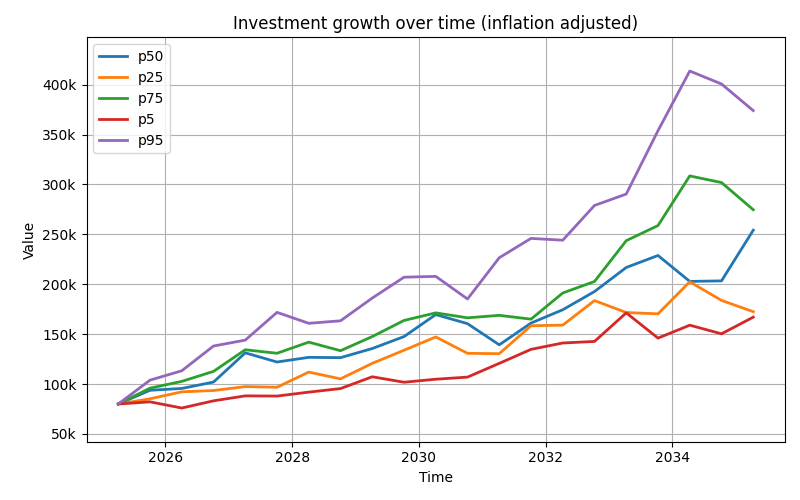

In [28]:
def on_config_change():
    TRAJECTORY_CACHE.reinit()
    asyncio.create_task(gen_and_append_trajectories(OPTIMAL_TRAJECTORY_COUNT))
    asyncio.create_task(run_dynamic_plot(fig=fig, ax=ax, lines=lines, update_period_in_secs=UPDATE_PERIOD_IN_SECS))

# Garbage-collect previous plots
matplotlib.pyplot.close('all')

fig, ax, lines = initialize_plot()

on_config_change()
make_ipw_dashboard()